# Prepare the phantom dataset for quality inspector

In [1]:
# import the necessary packages
import imutils
import matplotlib.pyplot as plt

import os
import numpy as np
from scipy import ndimage
from tqdm import tqdm  # ! this might result into problem with 'object'
import pandas as pd
import random
import glob
from skimage import io

import argparse
import time
import cv2

In [2]:
# visualization for two images

def subShow(IMG1, IMG2):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(IMG1, cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(IMG2, cmap='gray')
    plt.show()
    
    
# visualization for two images
def subShow3(IMG1, IMG2, IMG3):
    # plt.figure(figsize=(2, 3), dpi=250)
    
    plt.subplot(1,3,1)
    plt.imshow(IMG1, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1,3,2)
    plt.imshow(IMG2, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1,3,3)
    plt.imshow(IMG3, cmap='gray')
    plt.axis('off')
    plt.show()
    
def subShow4(IMG1, IMG2, IMG3, IMG4):
    # plt.figure(figsize=(2, 3), dpi=250)
    
    plt.subplot(1,4,1)
    plt.imshow(IMG1, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1,4,2)
    plt.imshow(IMG2, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1,4,3)
    plt.imshow(IMG3, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1,4,4)
    plt.imshow(IMG4, cmap='gray')
    plt.axis('off')
    plt.show()
    
def subShow3_HR(IMG1, IMG2, IMG3):
    plt.figure(figsize=(4, 6), dpi=250)
    
    plt.subplot(1,3,1)
    plt.imshow(IMG1, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1,3,2)
    plt.imshow(IMG2, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1,3,3)
    plt.imshow(IMG3, cmap='gray')
    plt.axis('off')
    plt.show()

In [3]:
# normalize into [0, 1]

def normStack(imageStack):
    
    Range = np.max(imageStack) - np.min(imageStack)
    normTemp = ((imageStack - np.min(imageStack))/Range - 0.5) * 2 
    
    return (normTemp +1)/2

## Get the phantom dataset

In [4]:
# CT phantom
from phantominator import shepp_logan
ph = shepp_logan(128)

# MR phantom (returns proton density, T1, and T2 maps)
M0, T1, T2 = shepp_logan((128, 128, 20), MR=True)

(128, 128, 20)


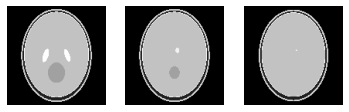

In [5]:
print(M0.shape)
index = 9
subShow3(M0[...,index], M0[...,index+1], M0[...,index+2])

In [6]:
print(M0[...,index].max(), M0[...,index].min())

0.9800000000000001 0.0


## Blurry use gaussian filter

0.0 255.0
0.0 226.54921343537416
0.0 239.9017384731671
0.0 255.00000000000014
0.0 255.00000000000003


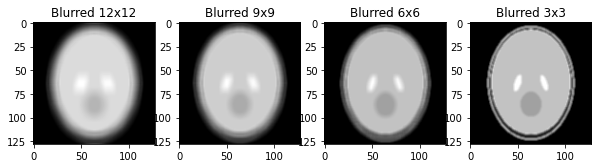

In [7]:
import numpy as np
from scipy import misc, signal
import matplotlib.pyplot as plt

# Load Lena image
image = M0[...,9]
image = np.divide(image, np.max(image))*255 # scale into [0, 1]
print(image.min(), image.max())
# print(image.min(), image.max())

kernel = [12, 9, 6, 3]
# Define square averaging masks
masks = [np.ones((n, n))/(n*n) for n in kernel]

# Apply Gaussian blur using convolution
blurred_images = []
for mask in masks:
    blurred = signal.convolve2d(image, mask, mode='same', boundary='symm')
    print(np.asarray(blurred).min(), np.asarray(blurred).max())
    blurred_images.append(blurred)

# Display original and blurred images
fig, axs = plt.subplots(1, len(kernel), figsize=(10, 5))
axs[0].imshow(image, cmap='gray')
axs[0].set_title('Original')

for i, mask in enumerate(masks):
    axs[i].imshow(blurred_images[i], cmap='gray')
    axs[i].set_title('Blurred {}x{}'.format(mask.shape[0], mask.shape[1]))
plt.show()


(1, 5, 128, 128)


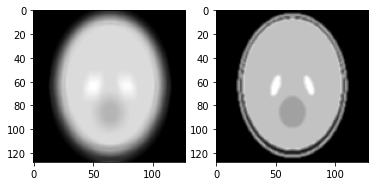

226.54921343537416 255.0 255.00000000000014


In [8]:
# normalize the images between [0, 1]

test = np.asarray(blurred_images)
# print(test.shape)
phan_stack = np.concatenate([test, np.expand_dims(image, axis=0)], axis=0)
phan_stack = np.expand_dims(phan_stack, axis=0)
print(phan_stack.shape)

# phan_stack = normStack(phan_stack)

subShow(phan_stack[0][0], phan_stack[0][3])
print(phan_stack[0][0].max(), phan_stack[0][4].max(), phan_stack.max())

## Pad images for later scanning

In [10]:
def padImg(imageStacks, padW, padH):
    
    stackPad = []

    for stack in range(imageStacks.shape[0]):
        tempStack = imageStacks[stack,...]
        # print('before:', tempStack.max())
        tempMean = np.round(np.mean(tempStack)).astype('float')  # mean of whole stack
        # print(stack, tempMean)
        tempStack = np.pad(tempStack, ((0,0), (padH,0), (padW,0)), 'constant', constant_values=1) 
        # print('after:', tempStack.max())
        stackPad.append(tempStack)
    
    return (np.asarray(stackPad))

In [11]:
# padding to avoid artifacts

# window size
(winW, winH) = (16, 16)

# pad parameters
(padW, padH) = (winW, winH)

In [12]:
# pad the images

phan_stack_pad = padImg(phan_stack, padW, padH)  

print('after pad:', phan_stack_pad.shape, phan_stack_pad.max())

after pad: (1, 5, 144, 144) 255.00000000000014


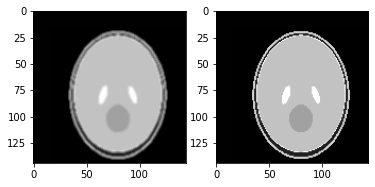

In [13]:
# sanity check

n_slice = 3
subShow(phan_stack_pad[0,n_slice,:,:], phan_stack_pad[0, n_slice+1,:,:])

## Calculate the quality inspector on sythetic dataset

In [15]:
# various blur detectors
import os
import numpy as np
from skimage import filters
import os
import cv2
import pywt
from skimage.filters.rank import entropy
from skimage.morphology import disk
import pywt

# brenner detector
def brenner(img):

    imgMat = img
    
    x, y = imgMat.shape
    score = 0
    for i in range(x - 2):
        for j in range(y - 2):
            score += (imgMat[i + 2, j] - imgMat[i, j]) ** 2

    return score

# tenengrad detector
def Tenengrad(img):

    f = img
    tmp = filters.sobel(f)
    source=np.sum(tmp**2)
    source=np.sqrt(source)

    return source

# laplacian
def laplacian(img):
    # img = (img-img.min())/img.mean()
    img = img/img.max()
    resLap = cv2.Laplacian(np.uint8(img), cv2.CV_8U)  # adapt to the images, did not change the distributions
    score = resLap.var()
    return score

# SMD
def SMD(img):

    f=img  # [0,1]
    x, y = f.shape
    score = 0
    for i in range(x - 1):
        for j in range(y - 1):
            score += np.abs(f[i+1,j]-f[i,j])+np.abs(f[i,j]-f[i+1,j])
    # score=score/100
    return score

# SMD2
def SMD2(img):

    f = img
    x, y = f.shape
    score = 0
    for i in range(x - 1):
        for j in range(y - 1):
            score += np.abs(f[i+1,j]-f[i,j])*np.abs(f[i,j]-f[i,j+1])

    return score

# Variance
def Variance(img):

    f = img
    score = np.var(f)
    return score

# Vollath
def Vollath(img):

    f = img
    source=0
    x,y=f.shape
    for i in range(x-1):
        for j in range(y):
            source+=f[i,j]*f[i+1,j]
    source=source-x*y*np.mean(f)
    
    return source

def calEntropy(img, diskNum):
    
    entropy_mat = entropy(img, disk(diskNum))  # Range is about [0, 6]
    # convert back to uint8
    entropy_frame = (entropy_mat * 255/np.max(entropy_mat)).astype(np.uint8)
    
    return entropy_frame.mean()

def DWT(img):
    # Compute the DWT coefficients
    coeffs = pywt.wavedec2(img, 'haar', level=5)

    # Extract the high-frequency sub-bands
    subbands = coeffs[1:]

    # Calculate the energy of each sub-band
    energies = []
    for subband in subbands:
        # Convert the sub-band tuple to a 2D matrix
        subband = np.asarray(subband)
        # Calculate the energy of the sub-band
        energy = (subband * subband).sum()
        energies.append(energy)
        
    return np.asarray(energies).sum()


def mkdir(path):
    folder = os.path.exists(path)
    if not folder:                   
        os.makedirs(path)  

In [16]:
# multiple scans for one image with quality detectors.
# input: stack num, slice num, image, step, windowsize, metric: indicate the metric for detecting

import numpy as np
from skimage import filters
import os
import cv2

# one image
def slidingStackQuality(stackNum, sliceNum, image, stepArray, windowSize, savedPath, metric):
    
    focalStack = []
    
    for i in range(len(stepArray)):
        
        stepSize = stepArray[i]
        # slide a window across the image
        feaMap = np.zeros((image.shape[:2]))  # careful the image is 3 channels

        for y in range(0, image.shape[0], stepSize):
            for x in range(0, image.shape[1], stepSize):
                # yield the current window
                yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])
                
                tPatch = image[y:y + windowSize[1], x:x + windowSize[0], 0]  # taking only 1 channel from 3
                
                #########
                if metric == 'std':
                    # Roy. calculate the std
                    tempPatch = np.ones((tPatch.shape)) * np.std((tPatch))
                    
                elif metric == 'brenner':
                    # print('cal robert', tPatch.shape, tPatch.min(), tPatch.max())
                    tempPatch = np.ones((tPatch.shape)) * np.round(brenner(tPatch), 2)
                    # print('robert mean:',tempPatch.mean())
                    
                elif metric == 'laplacian':
                    tempPatch = np.ones((tPatch.shape)) * np.round(laplacian(tPatch), 2)
                    # print('laplacian的数值：', np.round(laplacian(tPatch), 2))
                    
                elif metric == 'tenengrad':
                    tempPatch = np.ones((tPatch.shape)) * np.round(Tenengrad(tPatch), 2)
                    # print('raw tenengrad:', np.unique(tempPatch))
                    
                elif metric == 'SMD':
                    tempPatch = np.ones((tPatch.shape)) * np.round(SMD(tPatch), 2)
                    
                elif metric == 'SMD2':
                    tempPatch = np.ones((tPatch.shape)) * np.round(SMD2(tPatch), 2)
                    
                elif metric == 'Variance':
                    tempPatch = np.ones((tPatch.shape)) * np.round(Variance(tPatch), 2)
                    
                elif metric == 'Vollath':
                    tempPatch = np.ones((tPatch.shape)) * np.round(Vollath(tPatch), 2)
                    
                elif metric == 'DWT':
                    tempPatch = np.ones((tPatch.shape)) * np.round(DWT(tPatch), 2)
                
                
                feaMap[y:y + windowSize[1], x:x + windowSize[0]] = tempPatch + feaMap[y:y + windowSize[1], x:x + windowSize[0]]
                      
        focalStack.append(feaMap[padH:, padW:])  # crop the feature map back 
                           
    fMax = np.max(np.asarray(focalStack), axis=0)
                           
    # check the saving path
    tempPath = savedPath + '/' + str(stackNum)
    mkdir(tempPath)
    
    # save the max projection in sliceNum under the path 'stackNum'
    np.save(tempPath+'/'+str(sliceNum)+'.npy', fMax)
    # print('save sucessfully', sliceNum, tempPath)

In [17]:
# func for caluculate the stack

# input the normalized pad stacks
def std_map_cal(stacks, savedPath, stepArray, metric = 'std'):

    stepArray = stepArray
    targetStack = stacks
    
    # calculate the stack in metrics
    for stackNum in range(targetStack.shape[0]):

        for sliceNum in range(targetStack.shape[1]):
            image = np.stack((targetStack[stackNum,sliceNum,...],)*3, axis=-1) 
            for (x, y, window) in slidingStackQuality(stackNum, sliceNum, image, stepArray=stepArray, windowSize=(winW, winH), savedPath=savedPath, metric = metric):
            # if the window does not meet our desired window size, ignore it
                if window.shape[0] != winH or window.shape[1] != winW:
                    continue 

In [18]:
# target

patchStack = phan_stack_pad[0]

scoreStack = []

base_patch  = phan_stack_pad[0][0,...]  # first is weakest

for i in range(patchStack.shape[0]):
    print('current slice:', i)
    
    tempPatch = patchStack[i,...]

    # Laplacian
    laplacian1 = laplacian(base_patch)
    laplacian2 = laplacian(tempPatch)
    score3 = np.abs(laplacian1-laplacian2)/laplacian1
    print('laplacian:', laplacian1, laplacian2, np.round(score3, 2))


    # Variance
    Variance1 = Variance(base_patch)
    Variance2 = Variance(tempPatch)
    score6 = np.abs(Variance1-Variance2)/Variance1
    print('Variance:', Variance1, Variance2, np.round(score6, 2))


    # std
    std1 = np.std(base_patch)
    std2 = np.std(tempPatch)
    score8 = np.abs(std1-std2)/std1
    print('std:', std1, std2, np.round(score8, 2))
    
    # DWT
    dwt1 = DWT(base_patch)
    dwt2 = DWT(tempPatch)
    score10 = np.abs(dwt1-dwt2)/dwt1
    print('dwt:', dwt1, dwt2, np.round(score10, 2))
    
    # slice score
    tempScore = [score3, score6, score8, score10]
    scoreStack.append(tempScore)

scoreStack = np.asarray(scoreStack)

current slice: 0
laplacian: 0.00019286402368160334 0.00019286402368160334 0.0
Variance: 7474.640294759512 7474.640294759512 0.0
std: 86.45600207480977 86.45600207480977 0.0
dwt: 36849922.39253445 36849922.39253445 0.0
current slice: 1
laplacian: 0.00019286402368160334 0.00028926812735768166 0.5
Variance: 7474.640294759512 7701.50855210135 0.03
std: 86.45600207480977 87.75823922630484 0.02
dwt: 36849922.39253445 40084245.00714303 0.09
current slice: 2
laplacian: 0.00019286402368160334 0.000385653625590611 1.0
Variance: 7474.640294759512 7911.780564111846 0.06
std: 86.45600207480977 88.94819033635167 0.03
dwt: 36849922.39253445 42933915.719959565 0.17
current slice: 3
laplacian: 0.00019286402368160334 0.005387085128386488 26.93
Variance: 7474.640294759512 8232.028534056682 0.1
std: 86.45600207480977 90.73052702402143 0.05
dwt: 36849922.39253445 49490944.60598115 0.34
current slice: 4
laplacian: 0.00019286402368160334 0.007017638257792256 35.39
Variance: 7474.640294759512 9028.06304360098

### Calculate in multiple scales

In [19]:
# parameters for feature map

# step size
stepArray = [2,4,6,8]

# window size
(winW, winH) = (8,8)

# pad parameters
(padW, padH) = (winW, winH) 

filePath = 'xxx/deepFocus_phantom/' 

if not os.path.exists(filePath):
    # If the path does not exist, create it
    os.makedirs(filePath)
    # print('Path created:', tempPath)
else:
    pass

targetStack = phan_stack_pad
print(targetStack.shape)

(1, 5, 144, 144)


In [20]:
# metricList = ['std','laplacian','Variance', 'DWT']  # brenner, SMD, SMD2, Vollath is slow
metricList = ['Variance']

timeList = []

for metricTemp in enumerate(metricList):
    savedPath = filePath + str(metricTemp[1])
    # print(metricTemp[1])
    
    start_time = time.time()
    std_map_cal(targetStack, savedPath, stepArray, metric = str(metricTemp[1]))
    end_dwt = time.time() - start_time
    timeList.append(end_dwt)
    print(metricTemp[1], end_dwt)
    

Variance 2.153007745742798


## Sort stacks

In [22]:
# get one stack altogether

# define the read in function for max projection
import os
from natsort import natsorted

def readNpy(data_path):
    fStack = []
    file_list = natsorted(glob.glob(os.path.join(data_path, "*.npy")))
    # for img in glob.glob(os.path.join(data_path, "*.npy")):
    for img in file_list:
        im = np.load(os.path.join(data_path, img))
        # print(os.path.join(data_path, img))
        imarray = np.array(im)
        fStack.append(imarray)  # images, num of slices, channels, img.x, img.y
    return np.asarray(fStack)
        
def normStack(imageStack):
    
    Range = np.max(imageStack) - np.min(imageStack)
    normTemp = ((imageStack - np.min(imageStack))/Range - 0.5) * 2 
    
    return (normTemp +1)/2

In [23]:
def sortStack(filePath, metric):
    savedPathStack = filePath + str(metric)+'/'
    
    stacksNum = len(os.listdir(savedPathStack))
    print(savedPathStack, stacksNum)
    
    fStacks = []
    for i in range(stacksNum):
        # print('current slice:', i)
        fStackTemp = readNpy(savedPathStack+str(i))
        fStacks.append(fStackTemp)

    fStacks = np.asarray(fStacks)
    
    # normalize between 0, 1
    fStacks = normStack(fStacks)
    
    return fStacks

In [ ]:
# sort and normalize the images

filePath = '/bigdata/casus/MLID/RuiLi/Data/LM/deepFocus_phantom/'

dwt_stack = sortStack(filePath, 'DWT')[:,:,8:, 8:]
std_stack = sortStack(filePath, 'std')[:,:,8:, 8:]
var_stack = sortStack(filePath, 'Variance')[:,:,8:, 8:]
lap_stack = sortStack(filePath, 'laplacian')[:,:,8:, 8:]

(1, 5, 128, 128) 0.0 1.0


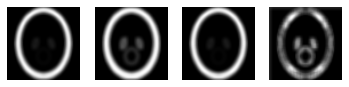

In [25]:
# sanity check

print(dwt_stack.shape, dwt_stack.min(), dwt_stack.max())

index = random.randint(0, dwt_stack.shape[0]-1)
slice_num = 4
subShow4(dwt_stack[index][slice_num], std_stack[index][slice_num], var_stack[index][slice_num], lap_stack[index][slice_num])

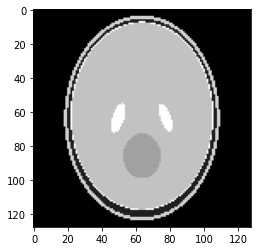

In [26]:
plt.imshow(phan_stack[0,4], cmap='gray')

In [27]:
FIG_PATH = '/home/li52/code/LM/digitalConfocal/reports/featureMap/update_032023/'

In [28]:
def save_svg(stack, metric, figPath):
    
    savePath = figPath + str(metric) + '/'
    folder = os.path.exists(savePath)
    if not folder:                   
        os.makedirs(savePath) 
    
    for index in range(stack.shape[1]):
        imgTemp = stack[0][index]
        plt.figure()
        plt.axis('off')
        plt.imshow(imgTemp, cmap='gray')
        plt.savefig(savePath + str(metric) + '_' + str(index) + '.svg')

In [ ]:
save_svg(phan_stack, 'raw', FIG_PATH)
save_svg(dwt_stack, 'dwt', FIG_PATH)
save_svg(std_stack, 'std', FIG_PATH)
save_svg(var_stack, 'var', FIG_PATH)
save_svg(lap_stack, 'lap', FIG_PATH)